This notebook was used at the beginning to check parts of the neural field implementation. The NeuralField class implementation is build on results from this notebook, however, the results shown here are not up to date anymore and do not necessarily represent the functions used in the current implementation of the NeuralField class. I plan to update some of the plots in this notebook with the current version soon. 

In [1]:
import sys
sys.path.append('../')
from inputs import two_dimensional_peak, three_dimensional_peak
from cedar_modules import GaussKernel, pad_and_convolve
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.signal
import pandas as pd
import json

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


%matplotlib inline
import seaborn

## Check current convolve function

In [10]:
# compare pad_and_convolve with just convolve with 'same' mode
kernel = GaussKernel(1,3,False,2)()

peak = [3,4]
test_input = np.zeros([10,10])
test_input[peak[0]-1:peak[0]+2, peak[1]-1:peak[1]+2] = 1

res_pac = pad_and_convolve(test_input, kernel, 'zero-filled border')
res_conv = scipy.signal.convolve(test_input, kernel, mode='same')

print((res_pac == res_conv).all())

(10, 10) (10, 10)
True


# Old convolve tests

In [39]:
def gauss_kernel_fn(d, c, s):
    return c * np.exp(- d**2 / (2 * s**2)) 

c = 1
s = 3

sizes = [10,10]

In [40]:
# def pad_flat_matrix(matrix_flat, dims, sizes, mode):
#     if mode == 'cyclic':
#         pad_mode = 'wrap'
#     elif mode == 'zero-filled borders':
#         pad_mode = 'constant'
#     else: 
#         print('Padding mode not known!')
#         return matrix_flat
        
#     if dims == 1:
#             matrix_padded = np.pad(matrix_flat, pad_width=int(sizes[0]/2), mode=pad_mode)

#     if dims == 2:
#         matrix_padded = np.pad(matrix_flat.reshape(sizes), 
#                                  pad_width=((int(sizes[0]/2), int(sizes[0]/2)),
#                                             (int(sizes[1]/2), int(sizes[1]/2))),
#                                  mode=pad_mode)

#     if dims == 3:
#         matrix_padded = np.pad(matrix_flat.reshape(sizes), 
#                                  pad_width=((int(sizes[0]/2), int(sizes[0]/2)),
#                                             (int(sizes[1]/2), int(sizes[2]/2)),
#                                             (int(sizes[2]/2), int(sizes[1]/2))),
#                                  mode=pad_mode)

#     return matrix_padded.flatten()


def compute_kernel(sigma, dims=2):
    
    kernel_width = int(np.ceil(sigma*5))
    if kernel_width % 2 == 0:
        kernel_width += 1
        
#     print(kernel_width)
    if dims == 1 or dims == 0:
        x = np.arange(kernel_width)
        
        cx = kernel_width//2
        if kernel_width % 2 == 0:
            kernel_width -= 0.5
        dx = np.abs(x - cx)
        
    elif dims == 2:
        # create kernel_matrix
        x = np.arange(kernel_width)
        y = np.arange(kernel_width)

        grid_x, grid_y = np.meshgrid(x,y)
        cx, cy = kernel_width//2, kernel_width//2
        if kernel_width % 2 == 0:
            cx -= 0.5
        if kernel_width % 2 == 0:
            cy -= 0.5
        dx = np.sqrt((grid_x-cx)**2 + (grid_y-cy)**2)

    elif dims == 3:
                # create kernel_matrix
        x = np.arange(kernel_width)
        y = np.arange(kernel_width)
        z = np.arange(kernel_width)

        grid_x, grid_y, grid_z = np.meshgrid(x,y,z)
        cx, cy, cz = kernel_width//2, kernel_width//2, kernel_width//2
        if kernel_width % 2 == 0:
            cx -= 0.5
        if kernel_width % 2 == 0:
            cy -= 0.5
        if kernel_width % 2 == 0:
            cz -= 0.5   
        dx = np.sqrt((grid_x-cx)**2 + (grid_y-cy)**2 + (grid_z-cz)**2)
    
        
    kernel_matrix = gauss_kernel_fn(dx, c, sigma)
    # normalize kernel
    kernel_matrix /= np.sum(kernel_matrix)
    
    if dims == 0:
        kernel_matrix = kernel_matrix[cx]
    
    return kernel_matrix


def new_scipy_convolution(inp, boundary, sigma):
    
    kernel_matrix = compute_kernel(sigma)
    
    new_scipy_conv = scipy.signal.convolve2d(inp, kernel_matrix, 
                                         boundary=boundary,
                                         mode='same')
    
    return new_scipy_conv, kernel_matrix


def pad_then_convolve(matrix, kernel, pad_size, boundary):
    
    kw = kernel.shape[0]

    pad_size_f = kw//2
    pad_size_b = kw//2 if kw % 2 == 1 else kw//2 -1
    inp_padded = np.pad(matrix, pad_width=(pad_size_f,pad_size_b),
                        mode=boundary)

    conv = scipy.signal.convolve(inp_padded, kernel,
                                               mode='valid')
   
    return conv
    
    
def scipy_convolve_with_pad(inp, border_type, sigma):
    
    kernel_width = int(np.ceil(sigma*5))
    if kernel_width % 2 == 0:
        kernel_width += 1
        
    dims = len(inp.shape)
    kernel_matrix = compute_kernel(sigma, dims)
    
    boundary = 'constant' if border_type == 'zero-filled borders' else 'wrap'
    pad_size = kernel_width//2
    
    conv = pad_then_convolve(inp, kernel_matrix, pad_size, boundary)

    
    return conv, kernel_matrix 

(10, 10) (10, 10)
True


# 2D convolution example

In [41]:
def convolution_plot(peak, border_type, sizes):
    test_input = np.zeros(sizes)
    test_input[peak[0]-1:peak[0]+2, peak[1]-1:peak[1]+2] = 1
    
    boundary = 'fill' if border_type == 'zero-filled borders' else 'wrap'
    
    conv_scipy_padded, km1 = scipy_convolve_with_pad(test_input, border_type, s)
    conv_scipy_new, km2 = new_scipy_convolution(test_input, boundary, s)
    
    interpolation = 'bilinear'
    
    plt.figure(figsize=(11,3))
    plt.suptitle('Bordertype: %s' %border_type, fontsize=17)
    
    plt.subplot(141)
    plt.title('Sigmoided Input', fontsize=10)
    plt.imshow(test_input, cmap='jet')
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(142)
    plt.title('Padded scipy convolution', fontsize=10)
    plt.imshow(conv_scipy_padded, cmap='jet', interpolation=interpolation)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(143)
    plt.title('New scipy convolution', fontsize=10)
    plt.imshow(conv_scipy_new, cmap='jet', interpolation=interpolation)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    
    plt.show()
    
    return conv_scipy_new, conv_scipy_padded, km1, km2

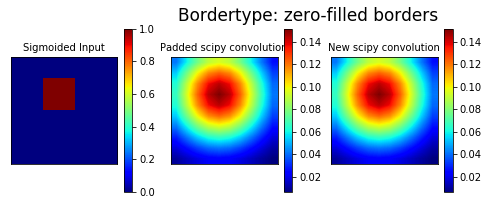

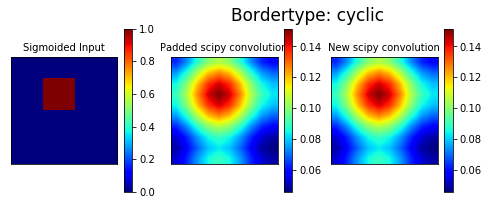

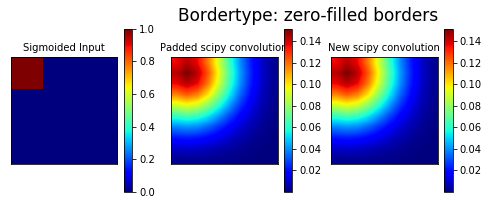

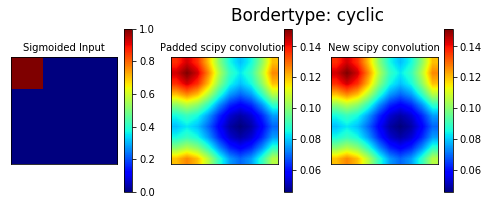

In [42]:
s=3
convolution_plot([3,4], 'zero-filled borders', [10,10])
convolution_plot([3,4], 'cyclic', [10,10])
# print('Convolution results for zero-filled borders')
sci, sci_padded, km1, km2 = convolution_plot([1,1], 'zero-filled borders', [10,10])
# print(np.array_equal(km1, km2)) # use the same kernel
# print((sci-sci_padded) < 10**-10) 
# difference very small, probably due to floating point errors
arrays = convolution_plot([1,1], 'cyclic', [10,10])

# 1D convolution example

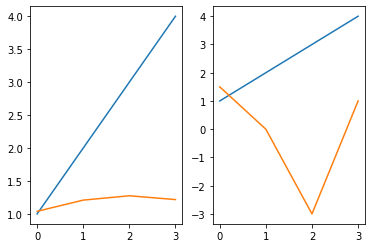

In [43]:
# 1-d and 3-d convolution

input_1d = np.array([1,2,3,4])
kernel = np.array([0.5,-1,2,-3,1])

rs_conv, kernel_ = scipy_convolve_with_pad(input_1d, 
                                          border_type='zero-filled borders', 
                                          sigma=s)

plt.figure()
plt.subplot(121)
plt.plot(input_1d)
# plt.plot(kernel)
plt.plot(rs_conv)

plt.subplot(122)
plt.plot(input_1d)
plt.plot(pad_then_convolve(input_1d, kernel, pad_size=kernel.shape[0]//2, boundary='constant'))

# 3D convolution example

In [44]:
# create sigmoided input as shown by cedar
input_3d = np.zeros((10,10,10))
input_3d[0,:3,:3] = 1
input_3d[1,:3,:3] = 1
input_3d[1,3,1] = 1
input_3d[1,1,3] = 1
input_3d[2,:3,:3] = 1
input_3d[3,1,1] = 1

# or alternatively use a gaussian as input
ampl = 6.5
std = 3.
# input_3d = three_dimensional_peak(1,1,1,std,ampl,10)

# kernel_3d = np.array([[[-1,1],[0,-1]],[[2,1],[1,1]]])
# print(kernel_3d.shape)
# test_conv_3d = pad_then_convolve(input_3d, kernel_3d, pad_size=kernel_3d.shape[0]//2, boundary='constant')
conv_res_3d, gauss_3d = scipy_convolve_with_pad(input_3d, 
                                                border_type='cyclic',
                                                sigma=1.5)

In [45]:
print(conv_res_3d.shape)

(10, 10, 10)


0.018940211136844926


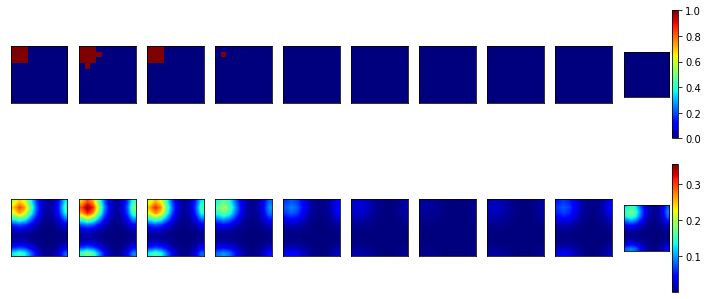

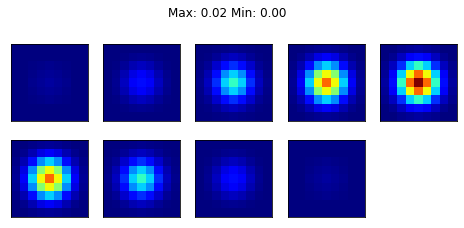

In [46]:
plt.figure(figsize=(12,8))
vmin_inp, vmax_inp = np.min(input_3d), np.max(input_3d)
vmin_conv = np.min(conv_res_3d)
vmax_conv = np.max(conv_res_3d)
vmin_gauss = np.min(gauss_3d)
vmax_gauss = np.max(gauss_3d)
# vmin_test = np.min(test_conv_3d)
# vmax_test = np.max(test_conv_3d)
print(vmax_gauss)

interpolation = 'bilinear'

for i in range(input_3d.shape[2]):
    plt.subplot(3,input_3d.shape[2], i+1)
    plt.imshow(input_3d[i,:,:], cmap='jet', vmin=vmin_inp, vmax=vmax_inp)
    plt.xticks([])
    plt.yticks([])
    if i == input_3d.shape[2] - 1:
        plt.colorbar()
    
    plt.subplot(3,conv_res_3d.shape[2],i+input_3d.shape[2]+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(conv_res_3d[i,:,:], cmap='jet', vmin=vmin_conv, vmax=vmax_conv,
               interpolation=interpolation)
    if i == input_3d.shape[2] - 1:
        plt.colorbar()
    
#     plt.subplot(3,conv_res_3d.shape[2],i+input_3d.shape[2]*2+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.imshow(test_conv_3d[i,:,:], cmap='jet', vmin=vmin_test, vmax=vmax_test)
#     if i == input_3d.shape[2] - 1:
#         plt.colorbar()
    
    
plt.figure(figsize=(8,5))
plt.suptitle('Max: %.2f Min: %.2f' %(vmax_gauss, vmin_gauss))
for i in range(gauss_3d.shape[0]):
    plt.subplot(3,5,i+1)
    plt.imshow(gauss_3d[i,:,:], cmap='jet', vmin=vmin_gauss, vmax=vmax_gauss)
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [47]:
print(pad_then_convolve(np.ones((2,2)), np.ones((2,2)),2, boundary='constant'))
scipy.signal.convolve2d(np.ones((2,2)), np.ones((2,2)), boundary='fill' ,mode='same')

[[1. 2.]
 [2. 4.]]


array([[1., 2.],
       [2., 4.]])

In [11]:
k_as_ar = np.array(1.5).reshape([]).flatten()
print(k_as_ar, type(k_as_ar), k_as_ar.shape[0])
print(np.array(1.5), np.array([1.5]))
print(scipy.signal.convolve((np.ones([])*1.5).reshape([]).flatten(), np.array([1.5]), mode='valid'))
np.product([10,10])

[1.5] <class 'numpy.ndarray'> 1
1.5 [1.5]
[2.25]


100

# Plot noise and check noise values

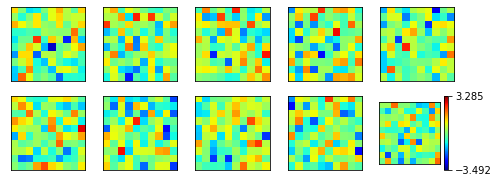

In [48]:
random_noise = np.random.randn(10,10,10)
rn_min = np.min(random_noise)
rn_max = np.max(random_noise)

plt.figure(figsize=(8,3))
for i in range(10):
    
    plt.subplot(2,5,i+1)
    plt.imshow(np.random.randn(10,10), cmap='jet', vmin=rn_min, vmax=rn_max)
    if i == 9:
        plt.colorbar(ticks=[rn_min, rn_max])
    plt.xticks([])
    plt.yticks([])

# Check sigmoid function

In [136]:
# class AbsSigmoid(object):
#     def __init__(self, beta=100):
#         self.beta = beta
#     def __call__(self, x):
#         return 0.5 * (1 + self.beta * x) / (1 + self.beta * np.abs(x)) + 0.5
    
class AbsSigmoid(object):
    def __init__(self, beta=100):
        self.beta = beta
    def __call__(self, x):
        return 0.5 * (1 + self.beta * x / (1 + self.beta * np.abs(x)))
    
    
class ExpSigmoid(object):
    def __init__(self, beta=100):
        self.beta = beta
    def __call__(self, x):
        return 1 / (1 + np.exp(- self.beta * x))

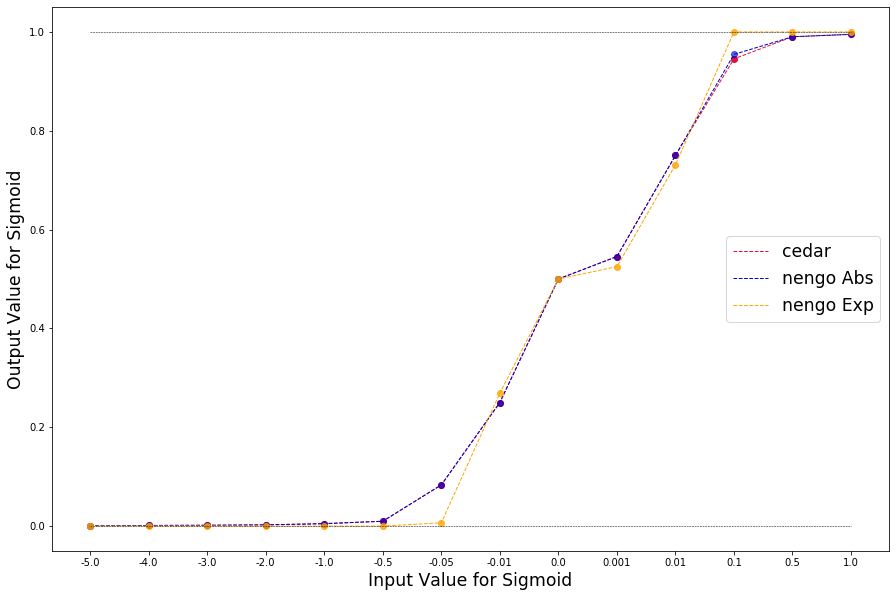

In [137]:
# sigmoids_cedar = [0.001, 0.00125, 0.0017, 0.0025, 0.00495, 0.0098, 0.0833, 0.25, 0.5, 
#                   0.5454, 0.75, 0.9455, 0.9902, 0.9951]
# sigmoid = AbsSigmoid(beta=100)
# vals = np.array([-5., -4., -3., -2., -1., -0.5, -0.05, -0.01, 0, 0.001, 0.01, 0.1, 0.5, 1.])
# sigmoids_nengo = sigmoid(vals)
# sigmoids_exp = ExpSigmoid()(vals)

# plt.figure(figsize=(15,10))
# vals_str = [str(val) for val in vals]
# plt.plot(vals_str, sigmoids_cedar, 'o', c='crimson')
# plt.plot(sigmoids_cedar, '--', c='crimson', linewidth=1, label='cedar')
# plt.plot(sigmoids_nengo, 'o', c='mediumblue', alpha=0.6)
# plt.plot(sigmoids_nengo, '--', c='mediumblue', linewidth=1, label='nengo Abs')
# plt.plot(sigmoids_exp, 'o', c='orange', alpha=0.8)
# plt.plot(sigmoids_exp, '--', c='orange', linewidth=1, label='nengo Exp')

# plt.plot([0,13],[1,1], '--', c='black', linewidth=0.5)
# plt.plot([0,13],[0,0], '--', c='black', linewidth=0.5)
# plt.xlabel('Input Value for Sigmoid', size='xx-large')
# plt.ylabel('Output Value for Sigmoid', size='xx-large')

# plt.legend(fontsize='xx-large')
# # plt.savefig('../Plots/sigmoids.pdf')
# plt.show()

In [21]:
boost = pd.read_csv('../recording_2019_08_14__11_42_17/Boost[OUTPUT].boost.csv')
boost = boost.drop(columns=['1','1.1']).rename(columns={'Mat': 'time','CV_32F': 'boost value'})
sigmoids_cedar_pd = pd.read_csv('../recording_2019_08_14__11_42_17/Static_Gain[OUTPUT].output.csv')
sigmoids_cedar_pd = sigmoids_cedar_pd.drop(columns=['1','1.1']).rename(columns={'Mat': 'time','CV_32F': 'sigmoid value'})

In [24]:
sigmoids_cedar_pd['boost value'] = boost['boost value']
sigmoids_cedar_pd.drop_duplicates(subset=['boost value'],keep='first', inplace=True)

In [50]:
sigmoids_cedar_pd.sort_values(by='boost value', inplace=True)

In [87]:
print(np.array(sigmoids_cedar_pd['boost value']))

[-2.0e+00 -1.9e+00 -1.8e+00 -1.7e+00 -1.6e+00 -1.5e+00 -1.4e+00 -1.3e+00
 -1.2e+00 -1.1e+00 -1.0e+00 -9.0e-01 -8.0e-01 -7.0e-01 -6.0e-01 -5.0e-01
 -4.5e-01 -4.0e-01 -3.5e-01 -3.3e-01 -3.0e-01 -2.5e-01 -2.0e-01 -1.5e-01
 -1.0e-01 -5.0e-02 -4.0e-02 -3.0e-02 -2.0e-02 -1.0e-02 -5.0e-03 -1.0e-03
 -0.0e+00  1.0e-03  2.0e-03  3.0e-03  4.0e-03  5.0e-03  6.0e-03  7.0e-03
  8.0e-03  9.0e-03  1.0e-02  2.0e-02  3.0e-02  4.0e-02  5.0e-02  6.0e-02
  7.0e-02  8.0e-02  9.0e-02  1.0e-01  1.5e-01  2.0e-01  2.5e-01  3.0e-01
  3.5e-01  4.0e-01  4.5e-01  5.0e-01  5.5e-01  6.0e-01  6.5e-01  7.0e-01
  7.5e-01  8.0e-01  8.5e-01  9.0e-01  9.5e-01  1.0e+00]


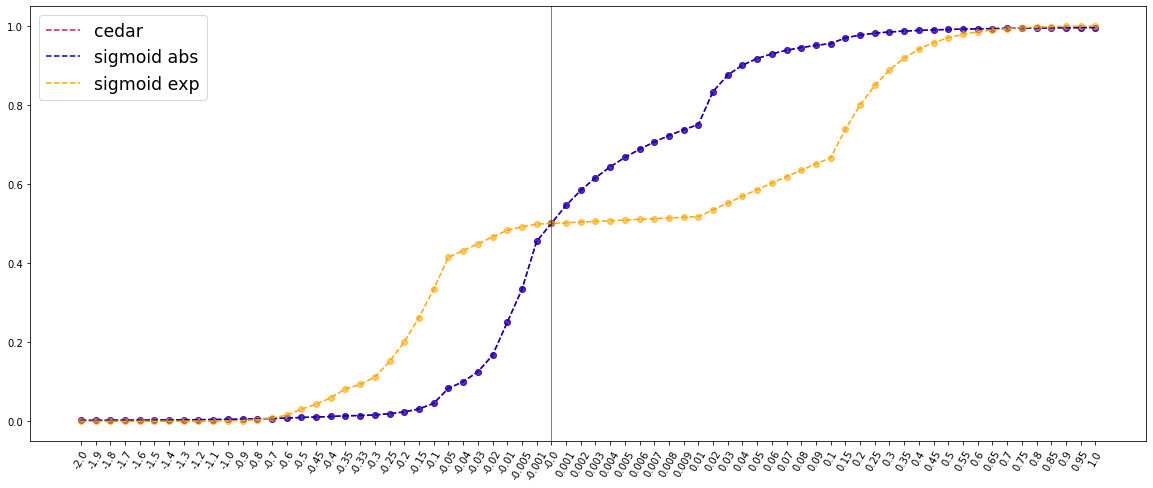

In [138]:
sigmoidabs = AbsSigmoid(beta=100)(sigmoids_cedar_pd['boost value'])
sigmoidexp = ExpSigmoid(beta=6.9)(sigmoids_cedar_pd['boost value'])

plt.figure(figsize=(20,8))
vals_str = [str(val) for val in sigmoids_cedar_pd['boost value'].round(decimals=3)]

plt.plot(vals_str, np.array(sigmoids_cedar_pd['sigmoid value']),'--', c='crimson', label='cedar')
plt.plot(np.array(sigmoids_cedar_pd['sigmoid value']),'o', c='crimson', alpha=0.6)
plt.plot(np.array(sigmoidabs),'o', c='mediumblue', alpha=0.6)
plt.plot(np.array(sigmoidexp),'o', c='orange', alpha=0.6)
plt.plot(np.array(sigmoidabs),'--', label='sigmoid abs', c='mediumblue')
plt.plot(np.array(sigmoidexp),'--', label='sigmoid exp', c='orange')
plt.legend(fontsize='xx-large')
plt.xticks(rotation=60)
plt.axvline(x=32, c='black', linewidth=0.5)

plt.show()

# Plot development for different taus

In [54]:
nengo_max_act = pd.read_csv('../Data/max_activaton_development_for_taus_3d_nengo.csv', index_col=0)
cedar_max_act = pd.read_csv('../Data/max_activaton_development_for_taus_3d_cedar.csv', header=0, index_col=0)

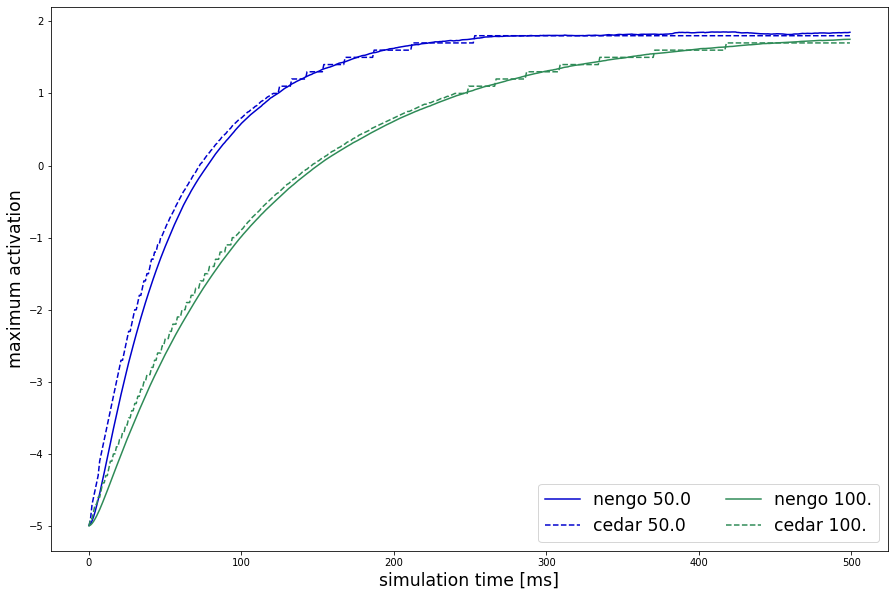

In [55]:
plt.figure(figsize=(15,10))
c = ['mediumblue', 'seagreen', 'crimson', 'orange', 'orangered']
for i, key in enumerate(nengo_max_act.keys()):
    plt.plot(np.arange(0,500,1), nengo_max_act[key][:500], label='nengo %s' %key[:4], c=c[i])
    plt.plot(np.arange(0,500,1), cedar_max_act[key][:500],'--', label='cedar %s' %key[:4], c=c[i])
plt.xlabel('simulation time [ms]', fontsize='xx-large')
plt.ylabel('maximum activation', fontsize='xx-large')
    
plt.legend(loc='lower right', fontsize='xx-large', ncol=2)
# plt.savefig('max_activation_for_taus_3d.pdf')
plt.show()